In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
NOFAULT_FILE = 'NoFault1.xlsx'
FAULTTYPE1_FILE = 'FaultType11.xlsx'
FAULTTYPE2_FILE = 'FaultType21.xlsx'
IDEAL_NOFAULT_FILE = 'NoFault.xlsx'
IDEAL_FAULTTYPE1_FILE = 'FaultType1.xlsx'
IDEAL_FAULTTYPE2_FILE = 'FaultType2.xlsx'


In [3]:
def load_data():
    nofault_df = pd.read_excel(NOFAULT_FILE)
    faulttype1_df = pd.read_excel(FAULTTYPE1_FILE)
    faulttype2_df = pd.read_excel(FAULTTYPE2_FILE)
    ideal_nofault_df = pd.read_excel(IDEAL_NOFAULT_FILE)
    ideal_faulttype1_df = pd.read_excel(IDEAL_FAULTTYPE1_FILE)
    ideal_faulttype2_df = pd.read_excel(IDEAL_FAULTTYPE2_FILE)
    return nofault_df, faulttype1_df, faulttype2_df, ideal_nofault_df, ideal_faulttype1_df, ideal_faulttype2_df

# Load the data
nofault_df, faulttype1_df, faulttype2_df, ideal_nofault_df, ideal_faulttype1_df, ideal_faulttype2_df = load_data()


In [4]:
def clean_nofault_data(df):
    df.replace(0, np.nan, inplace=True)
    df_cleaned = df.dropna(how='all').dropna(subset=df.columns.difference(['Serial Number']), how='all')
    for col in df_cleaned.columns:
        if col != 'Serial Number':
            df_cleaned.loc[:, col] = df_cleaned[col].fillna(df_cleaned[col].rolling(window=10, min_periods=1).mean())
    return df_cleaned

def fill_missing_values_with_lr(df):
    df_filled = df.copy()
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            not_null = df[col].notnull()
            X = np.arange(len(df)).reshape(-1, 1)
            y = df[col]
            lr = LinearRegression()
            lr.fit(X[not_null], y[not_null])
            df_filled[col] = lr.predict(X)
    return df_filled

def detect_wrong_values_with_lr(df):
    df_corrected = df.copy()
    for col in df.columns:
        X = np.arange(len(df)).reshape(-1, 1)
        y = df[col]
        lr = LinearRegression()
        lr.fit(X, y)
        predicted = lr.predict(X)
        threshold = 3 * np.std(y - predicted)
        wrong_indices = np.abs(y - predicted) > threshold
        if wrong_indices.any():
            df_corrected.loc[wrong_indices, col] = predicted[wrong_indices]
    return df_corrected

def clean_fault_data(df):
    df.replace(0, np.nan, inplace=True)
    df_cleaned = df.dropna()
    df_cleaned = fill_missing_values_with_lr(df_cleaned)
    df_cleaned = detect_wrong_values_with_lr(df_cleaned)
    return df_cleaned

# Clean the data
nofault_df_cleaned = clean_nofault_data(nofault_df)
faulttype1_df_cleaned = clean_fault_data(faulttype1_df)
faulttype2_df_cleaned = clean_fault_data(faulttype2_df)


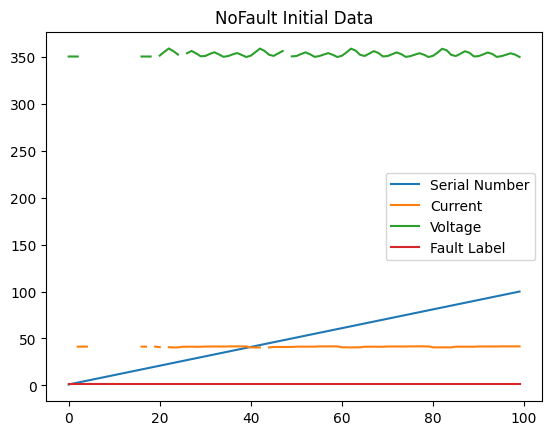

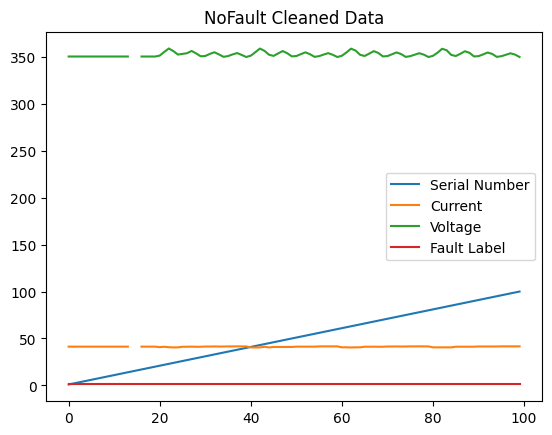

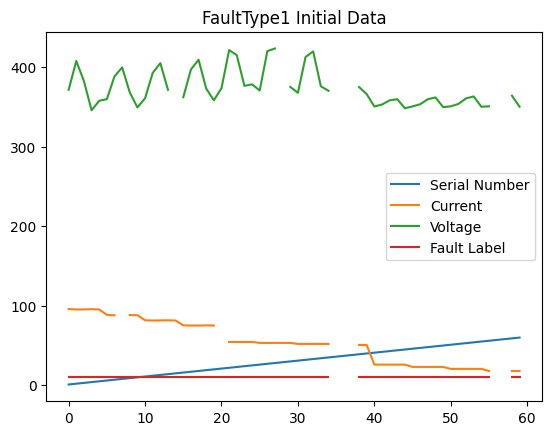

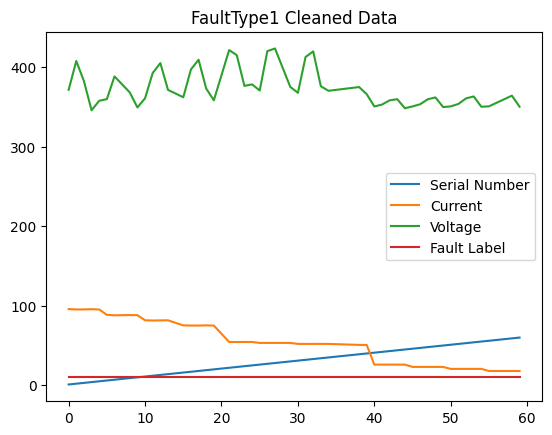

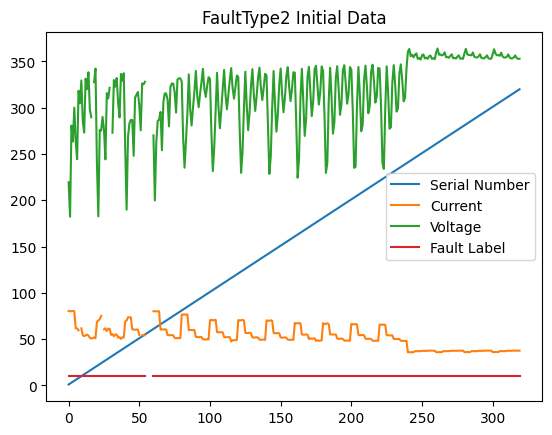

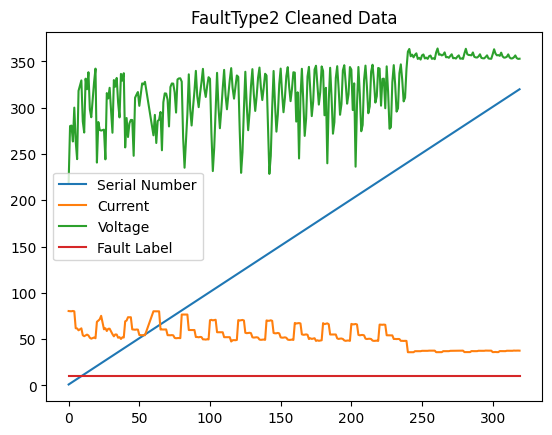

In [5]:
def plot_data(df, title):
    df.plot()
    plt.title(title)
    plt.show()

def plot_comparison(cleaned_df, ideal_df, title):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    cleaned_df.reset_index().plot(ax=axes[0], title=f'{title} - Cleaned Data')
    ideal_df.reset_index().plot(ax=axes[1], title=f'{title} - Ideal Data')
    plt.tight_layout()
    plt.show()

# Plot initial and cleaned data
plot_data(nofault_df, 'NoFault Initial Data')
plot_data(nofault_df_cleaned, 'NoFault Cleaned Data')
plot_data(faulttype1_df, 'FaultType1 Initial Data')
plot_data(faulttype1_df_cleaned, 'FaultType1 Cleaned Data')
plot_data(faulttype2_df, 'FaultType2 Initial Data')
plot_data(faulttype2_df_cleaned, 'FaultType2 Cleaned Data')


In [6]:
from sklearn.impute import SimpleImputer

def fill_missing_values(df):
    """
    Fill missing values using mean for numeric columns and mode for categorical columns.
    """
    imputer = SimpleImputer(strategy='mean')
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

def fill_missing_values_with_lr(df):
    """
    Fill missing values in a DataFrame using Linear Regression for each column.
    """
    df_filled = df.copy()
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            not_null = df[col].notnull()
            X = np.arange(len(df)).reshape(-1, 1)
            y = df[col]
            lr = LinearRegression()
            lr.fit(X[not_null], y[not_null])
            df_filled[col] = lr.predict(X)
    return df_filled

def align_datasets(cleaned_df, ideal_df):
    return cleaned_df.set_index('Serial Number').align(ideal_df.set_index('Serial Number'), join='inner', axis=0)

def evaluate_datasets(cleaned_df, ideal_df):
    cleaned_df = fill_missing_values(cleaned_df)
    ideal_df = fill_missing_values(ideal_df)
    
    mae = mean_absolute_error(ideal_df, cleaned_df)
    mse = mean_squared_error(ideal_df, cleaned_df)
    r2 = r2_score(ideal_df, cleaned_df)
    return mae, mse, r2

def align_and_evaluate(cleaned_df, ideal_df):
    aligned_cleaned_df, aligned_ideal_df = align_datasets(cleaned_df, ideal_df)
    
    # Fill missing values after alignment
    aligned_cleaned_df = fill_missing_values_with_lr(aligned_cleaned_df)
    aligned_ideal_df = fill_missing_values_with_lr(aligned_ideal_df)
    
    metrics = evaluate_datasets(aligned_cleaned_df, aligned_ideal_df)
    return aligned_cleaned_df, aligned_ideal_df, metrics

# Align and evaluate the cleaned datasets against the ideal datasets
aligned_nofault_df_cleaned, aligned_ideal_nofault_df, nofault_metrics = align_and_evaluate(nofault_df_cleaned, ideal_nofault_df)
aligned_faulttype1_df_cleaned, aligned_ideal_faulttype1_df, faulttype1_metrics = align_and_evaluate(faulttype1_df_cleaned, ideal_faulttype1_df)
aligned_faulttype2_df_cleaned, aligned_ideal_faulttype2_df, faulttype2_metrics = align_and_evaluate(faulttype2_df_cleaned, ideal_faulttype2_df)

# Print evaluation metrics
print(f"NoFault Evaluation: MAE: {nofault_metrics[0]}, MSE: {nofault_metrics[1]}, R²: {nofault_metrics[2]}")
print(f"FaultType1 Evaluation: MAE: {faulttype1_metrics[0]}, MSE: {faulttype1_metrics[1]}, R²: {faulttype1_metrics[2]}")
print(f"FaultType2 Evaluation: MAE: {faulttype2_metrics[0]}, MSE: {faulttype2_metrics[1]}, R²: {faulttype2_metrics[2]}")


NoFault Evaluation: MAE: 0.7057256653108276, MSE: 1.761767190829714, R²: 0.35295236349162823
FaultType1 Evaluation: MAE: 0.0, MSE: 0.0, R²: 1.0
FaultType2 Evaluation: MAE: 0.9199242832192601, MSE: 87.5882568865544, R²: 0.9367897160805126


In [7]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline

def fill_missing_values_with_spline_interpolation(df, s=0):
    df_filled = df.copy()
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            not_null = df[col].notnull()
            X = np.arange(len(df))
            y = df[col]

            # Fit spline interpolation model
            spline = UnivariateSpline(X[not_null], y[not_null], s=s)

            # Predict and fill NaN values
            y_pred = spline(X)
            df_filled[col] = df[col].fillna(pd.Series(y_pred, index=df.index))
    return df_filled

def detect_wrong_values_with_spline_interpolation(df, s=0):
    df_corrected = df.copy()
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            continue

        X = np.arange(len(df))
        y = df[col]

        # Fit spline interpolation model
        spline = UnivariateSpline(X, y, s=s)

        # Predict and correct values
        y_pred = spline(X)
        threshold = 3 * np.std(y - y_pred)
        wrong_indices = np.abs(y - y_pred) > threshold

        if wrong_indices.any():
            print(f"Alert: Wrong data detected in column '{col}' of Fault dataset. Correcting values.")
            # Explicitly cast predicted values to the same dtype as the column
            y_pred_casted = y_pred.astype(df[col].dtype)
            df_corrected.loc[wrong_indices, col] = y_pred_casted[wrong_indices]
    return df_corrected

# Apply these functions to clean the fault datasets
faulttype1_df_filled = fill_missing_values_with_spline_interpolation(faulttype1_df, s=0)
faulttype2_df_filled = fill_missing_values_with_spline_interpolation(faulttype2_df, s=0)

faulttype1_df_corrected = detect_wrong_values_with_spline_interpolation(faulttype1_df_filled, s=0)
faulttype2_df_corrected = detect_wrong_values_with_spline_interpolation(faulttype2_df_filled, s=0)


Alert: Wrong data detected in column 'Serial Number' of Fault dataset. Correcting values.
Alert: Wrong data detected in column 'Current' of Fault dataset. Correcting values.
Alert: Wrong data detected in column 'Serial Number' of Fault dataset. Correcting values.
Alert: Wrong data detected in column 'Current' of Fault dataset. Correcting values.
Alert: Wrong data detected in column 'Voltage' of Fault dataset. Correcting values.
Alert: Wrong data detected in column 'Fault Label' of Fault dataset. Correcting values.


In [8]:
aligned_nofault_df_cleaned, aligned_ideal_nofault_df, nofault_metrics = align_and_evaluate(nofault_df_cleaned, ideal_nofault_df)
aligned_faulttype1_df_cleaned, aligned_ideal_faulttype1_df, faulttype1_metrics = align_and_evaluate(faulttype1_df_corrected, ideal_faulttype1_df)
aligned_faulttype2_df_cleaned, aligned_ideal_faulttype2_df, faulttype2_metrics = align_and_evaluate(faulttype2_df_corrected, ideal_faulttype2_df)

# Print the evaluation metrics
print(f"NoFault Evaluation: MAE: {nofault_metrics[0]}, MSE: {nofault_metrics[1]}, R²: {nofault_metrics[2]}")
print(f"FaultType1 Evaluation: MAE: {faulttype1_metrics[0]}, MSE: {faulttype1_metrics[1]}, R²: {faulttype1_metrics[2]}")
print(f"FaultType2 Evaluation: MAE: {faulttype2_metrics[0]}, MSE: {faulttype2_metrics[1]}, R²: {faulttype2_metrics[2]}")


NoFault Evaluation: MAE: 0.7057256653108276, MSE: 1.761767190829714, R²: 0.35295236349162823
FaultType1 Evaluation: MAE: 0.8126870052132352, MSE: 18.11496158475033, R²: 0.631334935559214
FaultType2 Evaluation: MAE: 0.3527074110155925, MSE: 14.326735566461457, R²: 0.6454339456853395


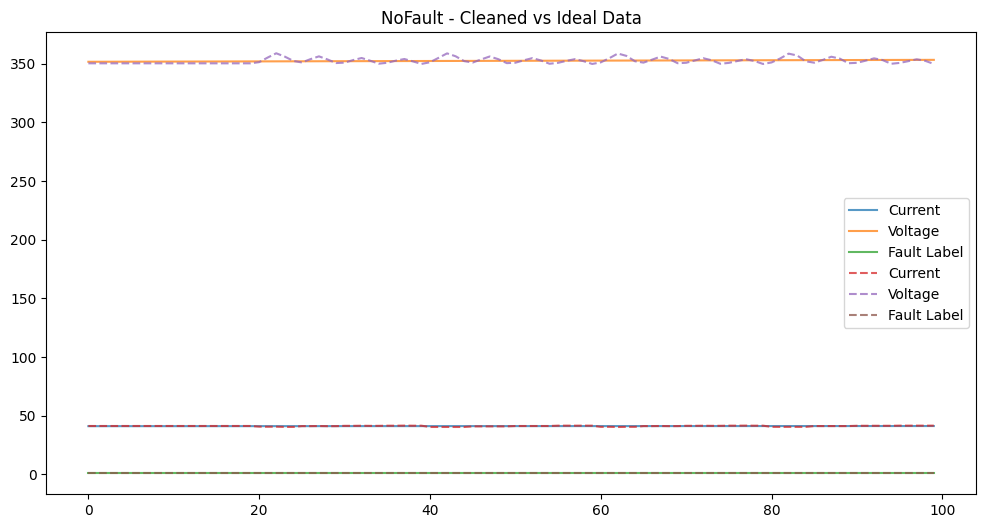

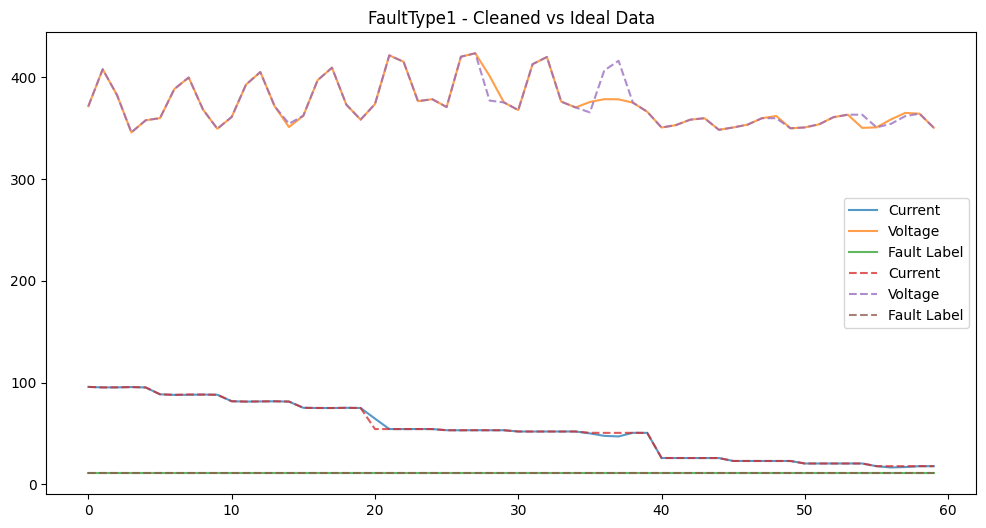

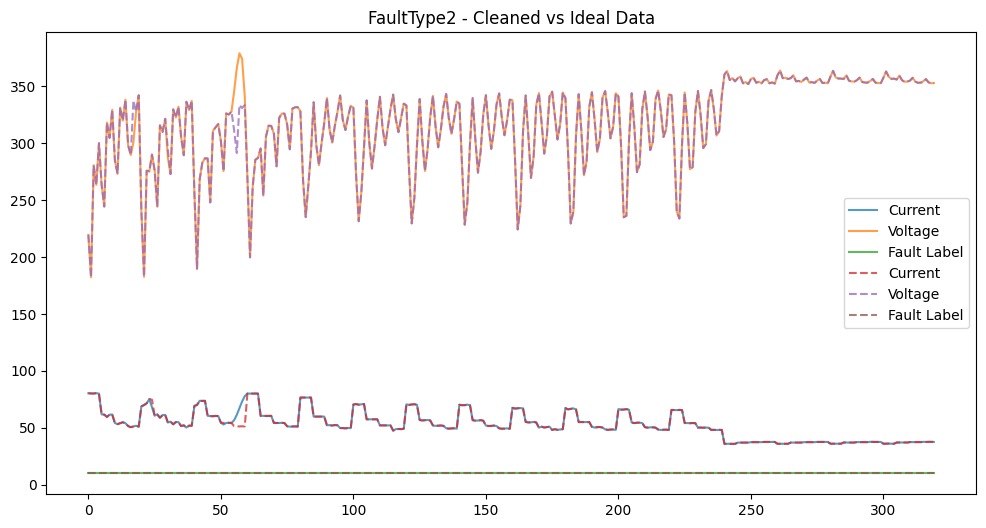

In [9]:
import matplotlib.pyplot as plt

def plot_comparison(cleaned_df, ideal_df, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    cleaned_df.reset_index(drop=True).plot(ax=ax, label='Cleaned Data', alpha=0.75)
    ideal_df.reset_index(drop=True).plot(ax=ax, linestyle='--', label='Ideal Data', alpha=0.75)
    plt.title(f'{title} - Cleaned vs Ideal Data')
    plt.legend()
    plt.show()

plot_comparison(aligned_nofault_df_cleaned, aligned_ideal_nofault_df, 'NoFault')
plot_comparison(aligned_faulttype1_df_cleaned, aligned_ideal_faulttype1_df, 'FaultType1')
plot_comparison(aligned_faulttype2_df_cleaned, aligned_ideal_faulttype2_df, 'FaultType2')


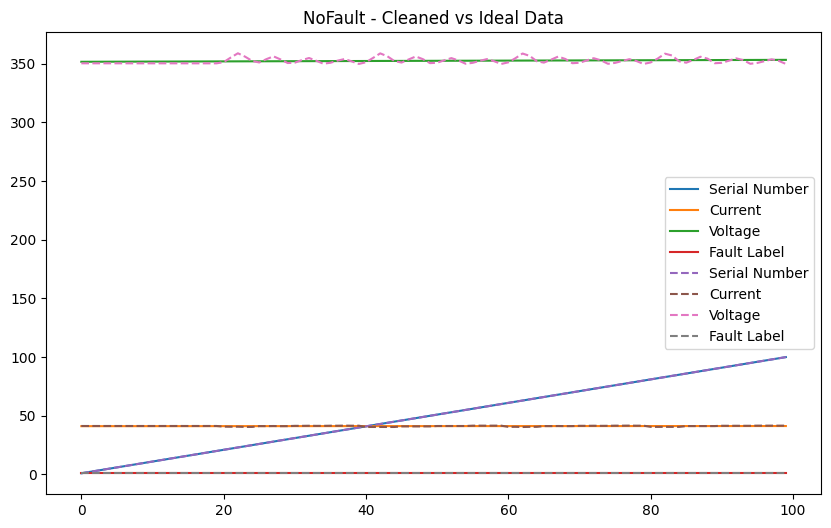

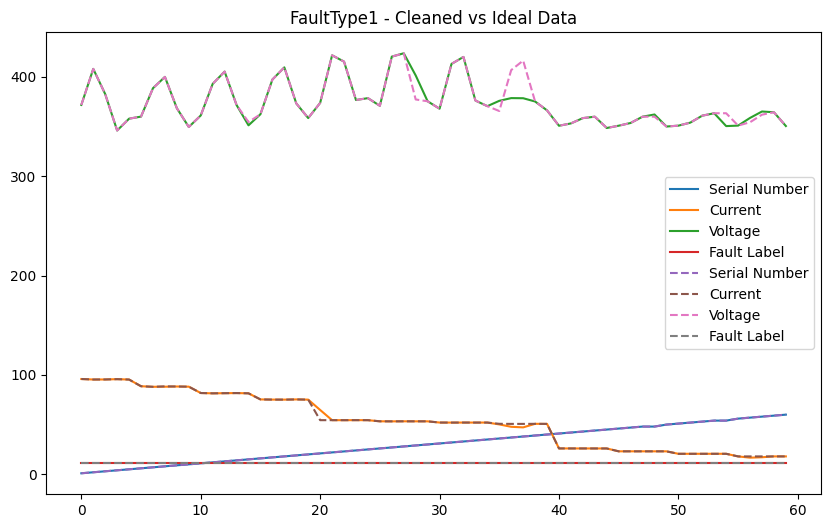

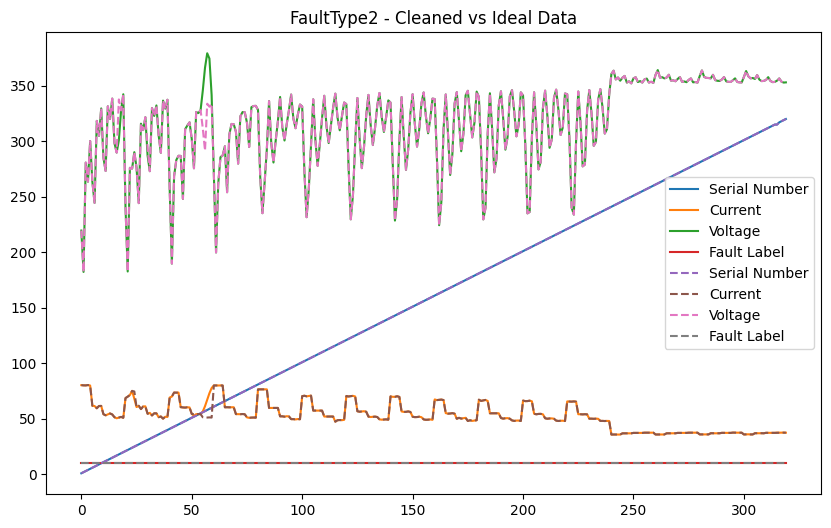

In [10]:
import matplotlib.pyplot as plt

# Plot cleaned vs. ideal data for visual comparison in single charts
def plot_comparison(cleaned_df, ideal_df, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    cleaned_df.reset_index().plot(ax=ax, label='Cleaned Data')
    ideal_df.reset_index().plot(ax=ax, label='Ideal Data', linestyle='--')
    plt.title(f'{title} - Cleaned vs Ideal Data')
    plt.legend()
    plt.show()

plot_comparison(aligned_nofault_df_cleaned, aligned_ideal_nofault_df, 'NoFault')
plot_comparison(aligned_faulttype1_df_cleaned, aligned_ideal_faulttype1_df, 'FaultType1')
plot_comparison(aligned_faulttype2_df_cleaned, aligned_ideal_faulttype2_df, 'FaultType2')


KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        96

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144

KNN Confusion Matrix:
[[30  0  0]
 [ 0 18  0]
 [ 0  0 96]]


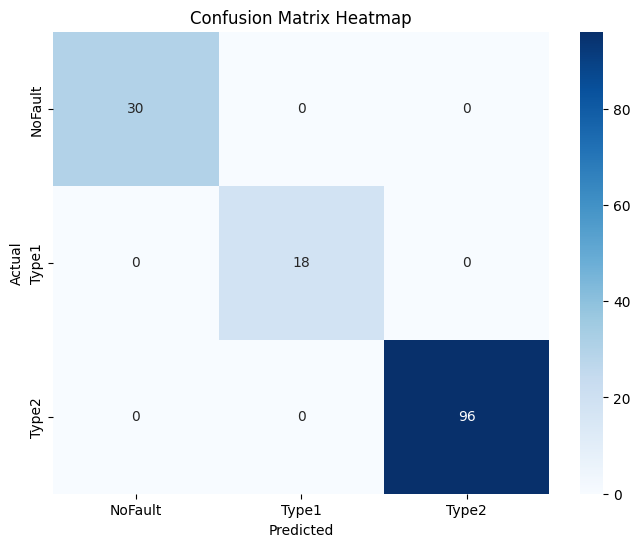

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Add fault labels
aligned_faulttype1_df_cleaned['FaultType'] = 'Type1'
aligned_faulttype2_df_cleaned['FaultType'] = 'Type2'
aligned_nofault_df_cleaned['FaultType'] = 'NoFault'

# Combine all data
df = pd.concat([aligned_faulttype1_df_cleaned, aligned_faulttype2_df_cleaned, aligned_nofault_df_cleaned], ignore_index=True)

# Encode the FaultType labels
label_encoder = LabelEncoder()
df['FaultTypeEncoded'] = label_encoder.fit_transform(df['FaultType'])

# Define features and target variable
X = df[['Current', 'Voltage']]
y = df['FaultTypeEncoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features by scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Train the KNN model
knn.fit(X_train_scaled, y_train)

# Predict using KNN
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate KNN
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("KNN Confusion Matrix:")
print(conf_matrix_knn)

# Plot KNN confusion matrix
plot_confusion_matrix(conf_matrix_knn, label_encoder.classes_)



Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        96

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144

Gradient Boosting Confusion Matrix:
[[30  0  0]
 [ 0 18  0]
 [ 0  0 96]]


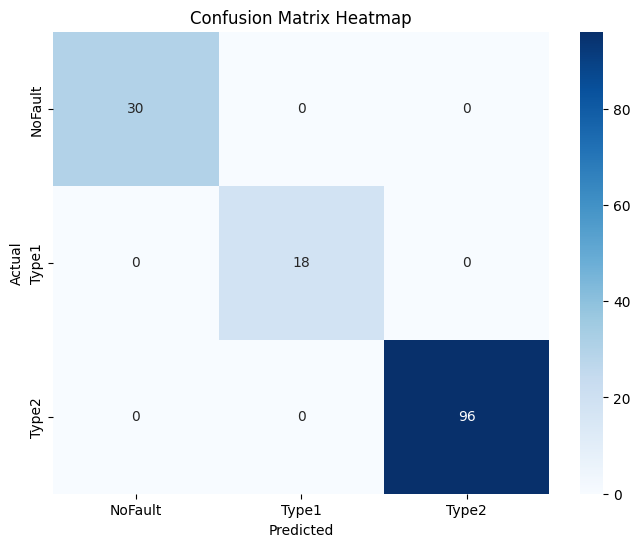

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=42)

# Train the model
gb.fit(X_train_scaled, y_train)

# Predict using Gradient Boosting
y_pred_gb = gb.predict(X_test_scaled)

# Evaluate Gradient Boosting
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("Gradient Boosting Confusion Matrix:")
print(conf_matrix_gb)

# Plot Gradient Boosting confusion matrix
plot_confusion_matrix(conf_matrix_gb, label_encoder.classes_)


MLP Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        96

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144

MLP Confusion Matrix:
[[30  0  0]
 [ 0 18  0]
 [ 0  0 96]]


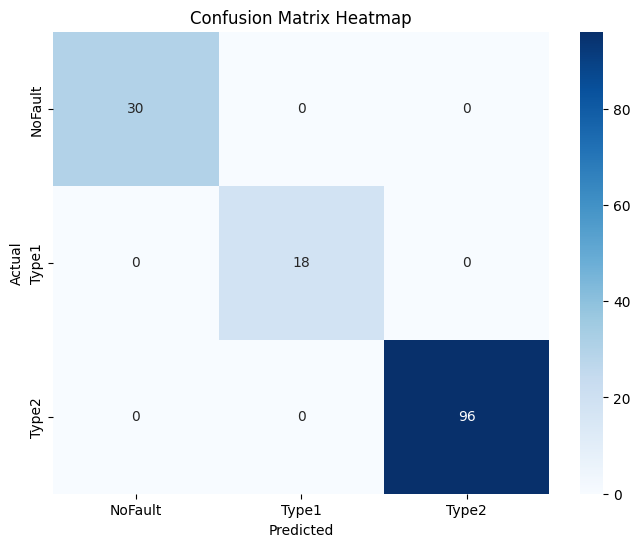

In [13]:
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize MLP classifier with increased max_iter
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Train the model
mlp.fit(X_train_scaled, y_train)

# Predict using MLP
y_pred_mlp = mlp.predict(X_test_scaled)

# Evaluate MLP
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
print("MLP Confusion Matrix:")
print(conf_matrix_mlp)

# Plot MLP confusion matrix
plot_confusion_matrix(conf_matrix_mlp, label_encoder.classes_)


   Serial Number   Current   Voltage  Fault Label
0              1  41.29325  350.3584            1
1              2  41.28514  350.3575            1
2              3  41.29660  350.3566            1
3              4  41.28280  350.3556            1
4              5  41.29857  350.3547            1


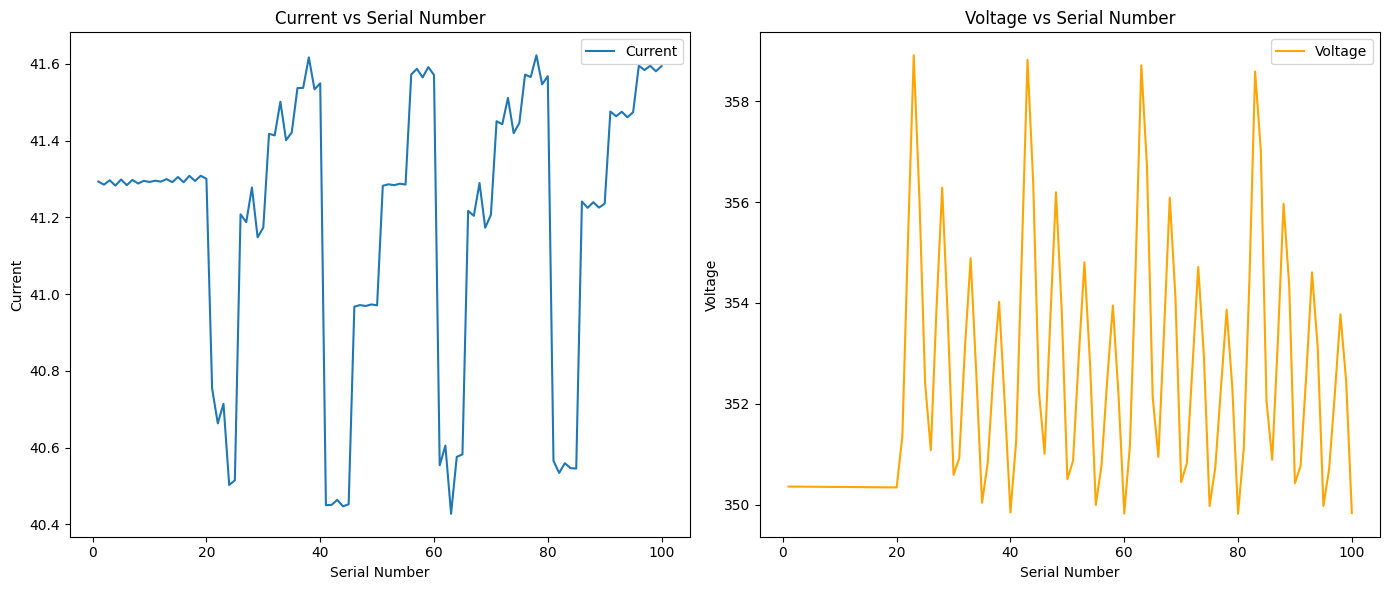

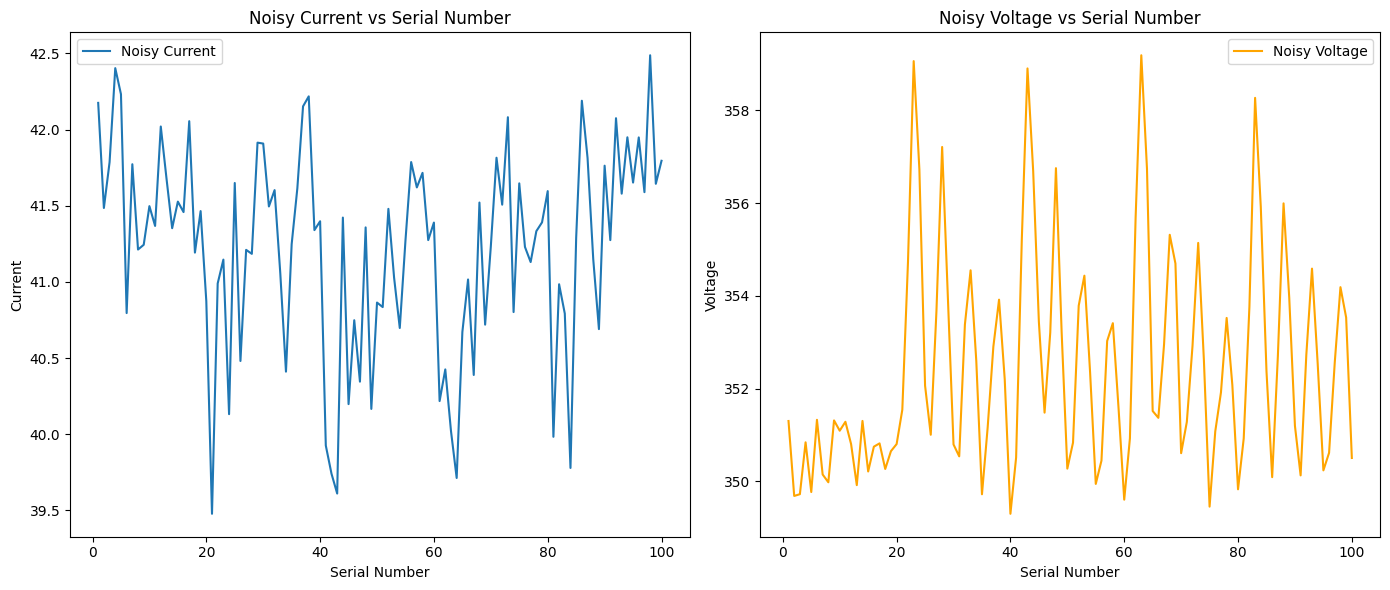

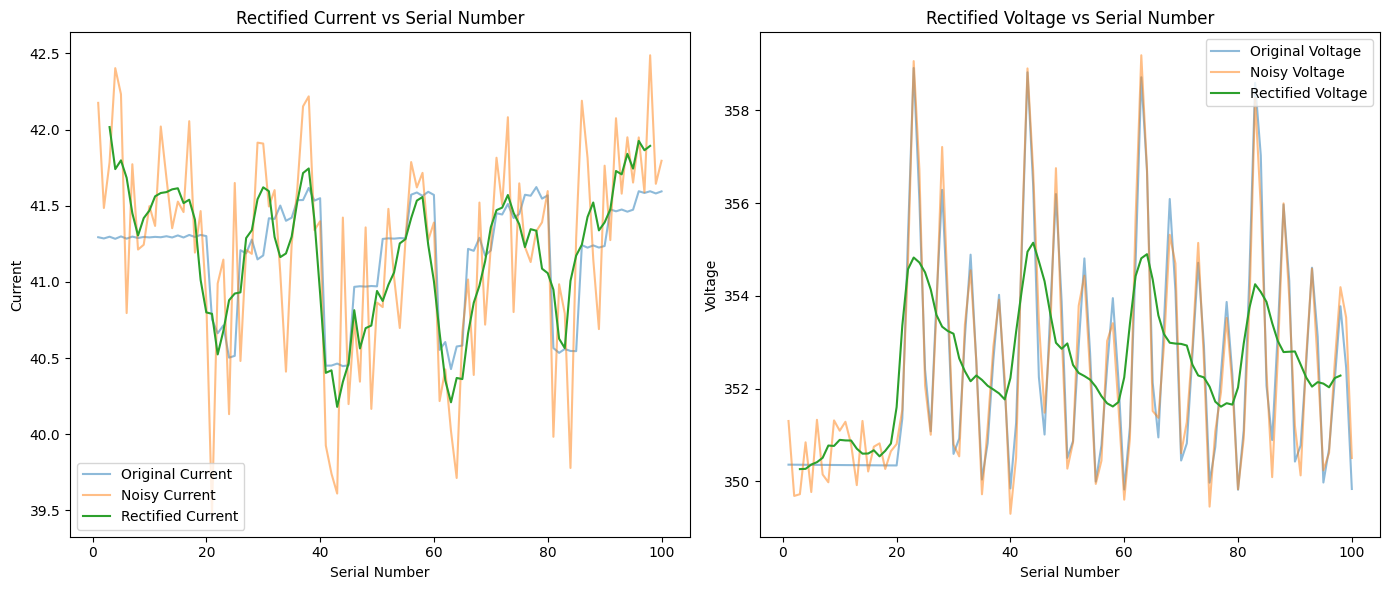

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the uploaded Excel file
file_path = 'NoFault.xlsx'  # Replace with the actual file path
data = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Plotting the original data
plt.figure(figsize=(14, 6))

# Subplot for Current
plt.subplot(1, 2, 1)
plt.plot(data['Serial Number'], data['Current'], label='Current')
plt.xlabel('Serial Number')
plt.ylabel('Current')
plt.title('Current vs Serial Number')
plt.legend()

# Subplot for Voltage
plt.subplot(1, 2, 2)
plt.plot(data['Serial Number'], data['Voltage'], label='Voltage', color='orange')
plt.xlabel('Serial Number')
plt.ylabel('Voltage')
plt.title('Voltage vs Serial Number')
plt.legend()

plt.tight_layout()
plt.show()

# Add noise to the data
np.random.seed(0)  # For reproducibility
noise_level = 0.5

noisy_current = data['Current'] + noise_level * np.random.normal(size=data.shape[0])
noisy_voltage = data['Voltage'] + noise_level * np.random.normal(size=data.shape[0])

# Plotting the noisy data
plt.figure(figsize=(14, 6))

# Subplot for Noisy Current
plt.subplot(1, 2, 1)
plt.plot(data['Serial Number'], noisy_current, label='Noisy Current')
plt.xlabel('Serial Number')
plt.ylabel('Current')
plt.title('Noisy Current vs Serial Number')
plt.legend()

# Subplot for Noisy Voltage
plt.subplot(1, 2, 2)
plt.plot(data['Serial Number'], noisy_voltage, label='Noisy Voltage', color='orange')
plt.xlabel('Serial Number')
plt.ylabel('Voltage')
plt.title('Noisy Voltage vs Serial Number')
plt.legend()

plt.tight_layout()
plt.show()

# Define a moving average filter
def moving_average(data, window_size):
    return data.rolling(window=window_size, center=True).mean()

# Apply the moving average filter to the noisy data
window_size = 5
rectified_current = moving_average(pd.Series(noisy_current), window_size)
rectified_voltage = moving_average(pd.Series(noisy_voltage), window_size)

# Plotting the rectified data
plt.figure(figsize=(14, 6))

# Subplot for Rectified Current
plt.subplot(1, 2, 1)
plt.plot(data['Serial Number'], data['Current'], label='Original Current', alpha=0.5)
plt.plot(data['Serial Number'], noisy_current, label='Noisy Current', alpha=0.5)
plt.plot(data['Serial Number'], rectified_current, label='Rectified Current')
plt.xlabel('Serial Number')
plt.ylabel('Current')
plt.title('Rectified Current vs Serial Number')
plt.legend()

# Subplot for Rectified Voltage
plt.subplot(1, 2, 2)
plt.plot(data['Serial Number'], data['Voltage'], label='Original Voltage', alpha=0.5)
plt.plot(data['Serial Number'], noisy_voltage, label='Noisy Voltage', alpha=0.5)
plt.plot(data['Serial Number'], rectified_voltage, label='Rectified Voltage')
plt.xlabel('Serial Number')
plt.ylabel('Voltage')
plt.title('Rectified Voltage vs Serial Number')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
def calculate_norm(aligned_cleaned_df, aligned_ideal_df):
    norm_current = np.linalg.norm(aligned_cleaned_df['Current'].values - aligned_ideal_df['Current'].values)
    norm_voltage = np.linalg.norm(aligned_cleaned_df['Voltage'].values - aligned_ideal_df['Voltage'].values)
    return norm_current, norm_voltage

# Calculate norms for aligned datasets
nofault_norm_current, nofault_norm_voltage = calculate_norm(aligned_nofault_df_cleaned, aligned_ideal_nofault_df)
faulttype1_norm_current, faulttype1_norm_voltage = calculate_norm(aligned_faulttype1_df_cleaned, aligned_ideal_faulttype1_df)
faulttype2_norm_current, faulttype2_norm_voltage = calculate_norm(aligned_faulttype2_df_cleaned, aligned_ideal_faulttype2_df)

# Print norm values
print(f"Norm for NoFault dataset - Current: {nofault_norm_current}, Voltage: {nofault_norm_voltage}")
print(f"Norm for FaultType1 dataset - Current: {faulttype1_norm_current}, Voltage: {faulttype1_norm_voltage}")
print(f"Norm for FaultType2 dataset - Current: {faulttype2_norm_current}, Voltage: {faulttype2_norm_voltage}")

Norm for NoFault dataset - Current: 3.592047329926209, Voltage: 22.70742947205791
Norm for FaultType1 dataset - Current: 11.359481243639017, Voltage: 55.96119433259509
Norm for FaultType2 dataset - Current: 40.16446333097436, Voltage: 110.1838555739352


In [1]:
import pandas as pd
import numpy as np

# Configuration
NOFAULT_FILE = 'NoFault1.xlsx'
FAULTTYPE1_FILE = 'FaultType11.xlsx'
FAULTTYPE2_FILE = 'FaultType21.xlsx'

def load_data(file_path):
    return pd.read_excel(file_path)

def find_and_correct_outliers(df, threshold=3):
    df_corrected = df.copy()

    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        std = df[col].std()
        outliers = ((df[col] - mean).abs() > threshold * std)

        # Correct outliers by replacing them with the median, cast to the original dtype
        median_value = df[col].median()
        df_corrected.loc[outliers, col] = median_value.astype(df[col].dtype)

    return df_corrected

def final_validation_checks(df, df_name):
    # Check for missing values
    missing_values = df.isnull().sum().sum()
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    
    # Check for remaining outliers
    outliers_count = 0
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        std = df[col].std()
        outliers = ((df[col] - mean).abs() > 3 * std)
        outliers_count += outliers.sum()
    
    # Check for data type consistency
    data_types = df.dtypes
    
    # Summary report
    print(f"Final Validation and Data Integrity Summary for {df_name} Dataset:")
    print(f"Missing Values: {missing_values}")
    print(f"Duplicate Records: {duplicates}")
    print(f"Remaining Outliers: {outliers_count}")
    print("Data Types:")
    print(data_types)
    print("\n")

# Load the data
nofault_df = load_data(NOFAULT_FILE)
faulttype1_df = load_data(FAULTTYPE1_FILE)
faulttype2_df = load_data(FAULTTYPE2_FILE)

# Find and correct outliers
nofault_df_corrected = find_and_correct_outliers(nofault_df)
faulttype1_df_corrected = find_and_correct_outliers(faulttype1_df)
faulttype2_df_corrected = find_and_correct_outliers(faulttype2_df)

# Perform final validation checks and print the data integrity summary
final_validation_checks(nofault_df_corrected, "NoFault")
final_validation_checks(faulttype1_df_corrected, "FaultType1")
final_validation_checks(faulttype2_df_corrected, "FaultType2")


Final Validation and Data Integrity Summary for NoFault Dataset:
Missing Values: 8
Duplicate Records: 0
Remaining Outliers: 0
Data Types:
Serial Number      int64
Current          float64
Voltage          float64
Fault Label        int64
dtype: object


Final Validation and Data Integrity Summary for FaultType1 Dataset:
Missing Values: 19
Duplicate Records: 0
Remaining Outliers: 0
Data Types:
Serial Number      int64
Current          float64
Voltage          float64
Fault Label      float64
dtype: object


Final Validation and Data Integrity Summary for FaultType2 Dataset:
Missing Values: 20
Duplicate Records: 0
Remaining Outliers: 0
Data Types:
Serial Number      int64
Current          float64
Voltage          float64
Fault Label      float64
dtype: object


